In [3]:
from qiskit import *
from qiskit import IBMQ, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
pi = np.pi
import pyscf
from qiskit_nature.second_q.drivers import PySCFDriver
import qiskit_nature.units as units
import qiskit_nature.second_q as sq
from qiskit_ibm_provider import IBMProvider
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager


In [4]:
BKconverter = sq.mappers.QubitConverter(sq.mappers.BravyiKitaevMapper())
JWconverter = sq.mappers.QubitConverter(sq.mappers.JordanWignerMapper())

# Initialize Molecule
driver = PySCFDriver(
    atom ='H 0 0 0; H 0 0 {}'.format(1.401),
    unit = units.DistanceUnit.BOHR,
    charge = 0,
    spin = 0,
    basis="sto3g"
)
hydrogen = driver.run()

# Get Hamiltonian and convert it to second quantized form
hamiltonian = hydrogen.hamiltonian
sq_form = hamiltonian.second_q_op()
repulsion = hamiltonian.nuclear_repulsion_energy

# Map SQ Hamiltonian onto Pauli matrices and store the necessary prefactors in a dictionary
BKconverter = sq.mappers.QubitConverter(sq.mappers.BravyiKitaevMapper())
JWconverter = sq.mappers.QubitConverter(sq.mappers.JordanWignerMapper())
BKHam = BKconverter.convert(sq_form)
JWHam = JWconverter.convert(sq_form)

coeffsBK = dict((x, np.real(y)) for x, y in BKHam.primitive.to_list())
coeffsJW = dict((x, np.real(y)) for x, y in JWHam.primitive.to_list())

# initialize the samplingrate (inverse trotter step size)
sampling_rate = 20
# points in time, at which U is simulated
t = np.arange(0, 1, 1/sampling_rate)
n = len(t)

# initialize Quantum Circuit
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)


#Bravyi-Kitaev Hamiltonian one Trotter step

#IIII
qc.p(-2*pi*coeffsBK['IIII']/sampling_rate, qr[0])
qc.x(qr[0])
qc.p(-2*pi*coeffsBK['IIII']/sampling_rate, qr[0])
qc.x(qr[0])

#IIIZ
qc.rz(2*2*pi*coeffsBK['IIIZ']/sampling_rate, qr[0])

#IIZI
qc.rz(2*pi*2*coeffsBK['IIZI']/sampling_rate, qr[1])

#IZII
qc.rz(2*pi*2*coeffsBK['IZII']/sampling_rate, qr[2])

#ZZZI
qc.cx(qr[3], qr[1])
qc.cx(qr[1], qr[2])
qc.rz(2*pi*2*coeffsBK['ZZZI']/sampling_rate, qr[2])
qc.cx(qr[1], qr[2])

#ZIZI
qc.rz(2*pi*2*coeffsBK['ZIZI']/sampling_rate, qr[1])
qc.cx(qr[3], qr[1])

#ZZIZ
qc.cx(qr[2], qr[0])
qc.cx(qr[0], qr[3])
qc.rz(2*pi*2*coeffsBK['ZZIZ']/sampling_rate, qr[3])
qc.cx(qr[0], qr[3])

#IZIZ
qc.rz(2*pi*2*coeffsBK['IZIZ']/sampling_rate, qr[0])
qc.cx(qr[2], qr[0])

#ZZZZ
qc.cx(qr[0], qr[1])
qc.cx(qr[1], qr[2])
qc.cx(qr[2], qr[3])
qc.rz(2*pi*2*coeffsBK['ZZZZ']/sampling_rate, qr[3])
qc.cx(qr[2], qr[3])

#IZZZ
qc.rz(2*pi*2*coeffsBK['IZZZ']/sampling_rate, qr[2])
qc.cx(qr[1], qr[2])

#IIZZ
qc.rz(2*pi*2*coeffsBK['IIZZ']/sampling_rate, qr[1])
qc.cx(qr[0], qr[1])

#ZXIX
qc.h(qr[2])
qc.h(qr[0])
qc.cx(qr[0], qr[2])
qc.cx(qr[2], qr[3])
qc.rz(2*pi*2*coeffsBK['ZXIX']/sampling_rate, qr[3])
qc.cx(qr[2], qr[3])

#IXZX
qc.cx(qr[2], qr[1])
qc.rz(2*pi*2*coeffsBK['IXZX']/sampling_rate, qr[1])

#ZXZX
qc.cx(qr[1], qr[3])
qc.rz(2*2*pi*coeffsBK['ZXZX']/sampling_rate, qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[1])

#IXIX
qc.rz(2*pi*2*coeffsBK['IXIX']/sampling_rate, qr[2])
qc.cx(qr[0], qr[2])
qc.h(qr[2])
qc.h(qr[0])

cUBK = qc.to_gate().control(1)
qc.clear()

# Jordan Wigner Hamiltonian one trotter step JW
#IIII
qc.p(-2*pi*coeffsJW['IIII']/sampling_rate, qr[0])
qc.x(qr[0])
qc.p(-2*pi*coeffsJW['IIII']/sampling_rate, qr[0])
qc.x(qr[0])

#IIIZ
qc.rz(2*pi*2*coeffsJW['IIIZ']/sampling_rate, qr[0])

#IIZI
qc.rz(2*pi*2*coeffsJW['IIZI']/sampling_rate, qr[1])

#IZII
qc.rz(2*pi*2*coeffsJW['IZII']/sampling_rate, qr[2])

#ZIII
qc.rz(2*pi*2*coeffsJW['ZIII']/sampling_rate, qr[3])

#IIZZ
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['IIZZ']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])

#IZIZ
qc.cx(qr[2], qr[0])
qc.rz(2*pi*2*coeffsJW['IZIZ']/sampling_rate, qr[0])
qc.cx(qr[2], qr[0])

#ZIIZ
qc.cx(qr[3], qr[0])
qc.rz(2*pi*2*coeffsJW['ZIIZ']/sampling_rate, qr[0])
qc.cx(qr[3], qr[0])

#IZZI
qc.cx(qr[2], qr[1])
qc.rz(2*pi*2*coeffsJW['IZZI']/sampling_rate, qr[1])
qc.cx(qr[2], qr[1])

#ZIZI
qc.cx(qr[3], qr[1])
qc.rz(2*pi*2*coeffsJW['ZIZI']/sampling_rate, qr[1])
qc.cx(qr[3], qr[1])

#ZZII
qc.cx(qr[3], qr[2])
qc.rz(2*pi*2*coeffsJW['ZZII']/sampling_rate, qr[2])
qc.cx(qr[3], qr[2])

#YYYY
qc.rx(-pi/2, qr[0])
qc.rx(-pi/2, qr[1])
qc.rx(-pi/2, qr[2])
qc.rx(-pi/2, qr[3])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['YYYY']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.rx(pi/2, qr[0])
qc.rx(pi/2, qr[1])
qc.rx(pi/2, qr[2])
qc.rx(pi/2, qr[3])

#XXXX
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['XXXX']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])

#XXYY
qc.h(qr[3])
qc.h(qr[2])
qc.rx(-pi/2, qr[1])
qc.rx(-pi/2, qr[0])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['XXYY']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.h(qr[3])
qc.h(qr[2])
qc.rx(pi/2, qr[1])
qc.rx(pi/2, qr[0])

#YYXX
qc.rx(-pi/2, qr[3])
qc.rx(-pi/2, qr[2])
qc.h(qr[1])
qc.h(qr[0])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['YYXX']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.rx(pi/2, qr[3])
qc.rx(pi/2, qr[2])
qc.h(qr[1])
qc.h(qr[0])

cUJW = qc.to_gate().control(1)
qc.clear()

In [30]:
# initialize new circuit
qreg = QuantumRegister(5)
creg = ClassicalRegister(1)
circ = QuantumCircuit(qreg, creg)

# simulate BK Hamiltonian for real part of U, t fixed, Trotter steps increasing
for i in range(n):
    # set the initial state
    circ.x(qreg[0])
    circ.x(qreg[1])
    circ.x(qreg[2])
    #circ.x(qreg[3])
    
    #perform Hadamard test
    circ.h(qreg[4])
    for _ in range(i):
        circ.append(cUBK, [4, 0, 1, 2, 3])
    circ.h(qreg[4])
    circ.measure(qreg[4], creg[0])
    
    #save circuit as QASM file
    circ.qasm(filename='Circuits_BK/Circuit_BK_{}.qasm'.format(i))
    circ.clear()

# simulate JW Hamiltonian for real part of U, t fixed, Trotter steps increasing
circ.clear()
for i in range(n):
    # set the initial state
    circ.x(qreg[0])
    #circ.x(qreg[1])
    circ.x(qreg[2])
    #circ.x(qreg[3])

    #perform Hadamard test
    circ.h(qreg[4])
    for _ in range(i):
        circ.append(cUJW, [4, 0, 1, 2, 3])
    circ.h(qreg[4])
    circ.measure(qreg[4], creg[0])
    
    #save circuit as QASM file
    circ.qasm(filename='Circuits_JW/Circuit_JW_{}.qasm'.format(i))
    circ.clear()

"\n# simulate BK Hamiltonian for real part of U, t fixed, Trotter steps increasing\nfor i in range(n):\n    circ.h(qreg[4])\n    circ.x(qreg[0])\n    circ.x(qreg[1])\n    circ.x(qreg[2])\n    #circ.x(qreg[3])\n    for _ in range(i):\n        circ.append(cUBK, [4, 0, 1, 2, 3])\n    circ.h(qreg[4])\n    circ.measure(qreg[4], creg[0])\n    circ.qasm(filename='Circuits_BK/Circuit_BK_{}.qasm'.format(i))\n    circ.clear()\n    \n    QC_circuit = transpile(circ, backend=backend)\n    result = backend.run(QC_circuit, shots=shots).result()\n    counts = result.get_counts(0)\n    if '1' in counts and '0' in counts:\n        time_evolution_BK[i] = (counts['0'] - counts['1']) / shots\n    elif '1' in counts:\n        time_evolution_BK[i] = -1\n    else:\n        time_evolution_BK[i] = 1\n\n# Plot of the time evolution\n#plt.plot(t, time_evolution_BK, 'k-')\n#plt.xlabel('time (a.u.)')\n#plt.ylabel('Re(U)')\n\n# Fourier analysis of the BK time evolution, to obtain frequencies and thus eigenenergies\

In [33]:
#Log into IBMQ and get the quantum computer backend
APITOKEN = 'MY API TOKEN'
IBMQ.save_account(APITOKEN)
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q')
backend=provider.get_backend('ibm_lagos')

configrc.store_credentials:WARNING:2023-03-31 08:46:43,695: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-03-31 08:46:44,022: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
#Store all circuits previously defined in an array
qc_list_BK = [0 for _ in range(n)]
qc_list_JW = [0 for _ in range(n)]

#transpiling decomposes complex gates into more basic gates, that the backend supports
for i in range(n):
    qc_list_BK[i] = transpile(QuantumCircuit.from_qasm_file('Circuits_BK/Circuit_BK_{}.qasm'.format(i)), backend=backend)
    qc_list_JW[i] = transpile(QuantumCircuit.from_qasm_file('Circuits_JW/Circuit_JW_{}.qasm'.format(i)), backend=backend)
qc_list = qc_list_BK + qc_list_JW

# Run the circuits on the quantum computer
shots = backend.configuration().max_shots
job_manager = IBMQJobManager()
job = job_manager.run(qc_list, backend=backend, name='job_name',shots=shots) 

In [5]:
#if you exit the notebook and reopen it, you have lose the job variable. To get access to it use
jobs=backend.jobs(job_name='job_name')#it is a list of length 1 if you have one job

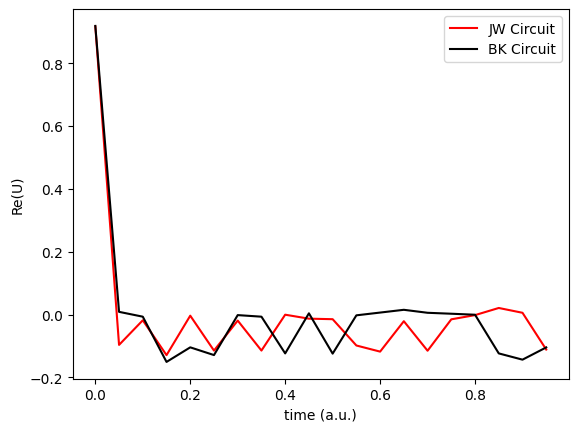

In [41]:
# Evaluate the data, get the time evolution and plot them
counts_list = jobs[0].result().get_counts()
time_evolution_BK = np.zeros(n)
time_evolution_JW = np.zeros(n)
for i in range(n):
    counts_BK = counts_list[i]
    counts_JW = counts_list[i+n]
    if '1' in counts_BK and '0' in counts_BK:
        time_evolution_BK[i] = (counts_BK['0'] - counts_BK['1']) / shots
    elif '1' in counts_BK:
        time_evolution_BK[i] = -1
    else:
        time_evolution_BK[i] = 1
    if '1' in counts_JW and '0' in counts_JW:
        time_evolution_JW[i] = (counts_JW['0'] - counts_JW['1']) / shots
    elif '1' in counts_JW:
        time_evolution_JW[i] = -1
    else:
        time_evolution_JW[i] = 1

plt.plot(t, time_evolution_JW, 'r-', label='JW Circuit')
plt.plot(t, time_evolution_BK, 'k-', label='BK Circuit')
plt.xlabel('time (a.u.)')
plt.ylabel('Re(U)')
plt.legend()
plt.savefig('Simulation on Quantum Computer.pdf')